In [1]:
from manim import *
from matplotlib.pyplot import tight_layout

from manim_custom import *
from manim_mobject_svg import *
from manim_custom.models import BinaryTree

quality = "ql"
config['background_color'] = WHITE

In [2]:
import openseespy.opensees as ops
import numpy as np


def analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A_list, E_list):
    """
    Parameters:
        nodes: np.array of shape (n_nodes, 3)
        connectivity_matrix: np.array of shape (n_elements, 2)
        supports: dict {node_index: (fix_x, fix_y)}
        loads: dict {node_index: [Fx, Fy]}
        A_list: list of cross-sectional areas (length = n_elements)
        E_list: list of Young's moduli (length = n_elements)

    Returns:
        displacements: dict {node_index: [ux, uy]}
    """

    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 2)

    # Create nodes
    for i, (x, y, _) in enumerate(nodes):
        ops.node(i, x, y)

    # Supports
    for node_id, (fix_x, fix_y) in supports.items():
        ops.fix(node_id, int(fix_x), int(fix_y))

    # Define elements and materials
    for i, (ni, nj) in enumerate(connectivity_matrix):
        E = E_list[i]
        A = A_list[i]
        ops.uniaxialMaterial("Elastic", i, E)
        ops.element("truss", i, int(ni), int(nj), A, i)

    # Apply loads
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)
    for node_id, (Fx, Fy) in loads.items():
        ops.load(node_id, Fx, Fy)

    # Static analysis
    ops.system("SparseGeneral")
    ops.numberer("RCM")
    ops.constraints("Plain")
    ops.integrator("LoadControl", 1.0)
    ops.algorithm("Linear")
    ops.analysis("Static")
    ops.analyze(1)

    # Get displacements
    displacements = np.array([
        [ops.nodeDisp(i, 1), ops.nodeDisp(i, 2)]
        for i in range(len(nodes))
    ])

    forces = np.array([ops.eleResponse(i, 'axialForce')[0] for i in range(len(connectivity_matrix))])

    return displacements, forces

Manim Community v0.19.0

(16, 3)


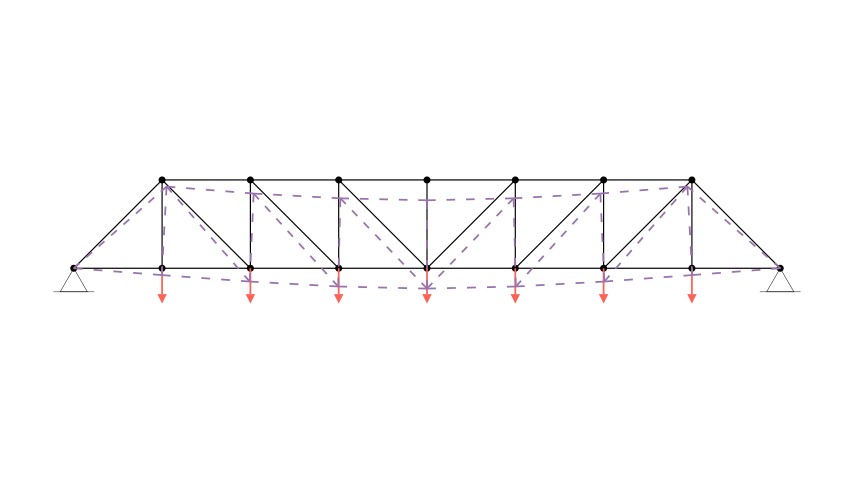

In [92]:
class ReferenceTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(5.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [[i * 7.5, 0, 0] for i in range(9)] +
            [[60 - (i + 1) * 7.5, 7.5, 0] for i in range(7)],
            dtype=float
        )

        connectivity_matrix = np.array(
            [[i, i + 1] for i in range(15)] +
            [[0, 15]] +
            [[i, 16 - i] for i in range(1, 8)] +
            [[i, 17 - i] for i in range(2, 5)] +
            [[i, 15 - i] for i in range(4, 7)],
            dtype=int
        )

        supports = {0: (True, True), 8: (True, True)}

        A = [.1] * len(connectivity_matrix)
        E = [210e9] * len(connectivity_matrix)

        loads = {k: (0., -1000.e3) for k in range(1, 8)}
        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  display_loads=True,
                  loads=loads,
                  displacements=u,
                  display_load_labels=False,
                  display_node_labels=False,
                  display_member_labels=False,
                  load_style={'scale': 3, 'stroke_width': 15},
                  tip_style={'tip_width': .8, 'tip_length': .8},
                  node_label_style={'font_size': 130},
                  node_label_offsets=[1.5 * LEFT] + [1.5 * DOWN for _ in range(1, 8)] +
                                     [1.5 * RIGHT] + [1.5 * UP for _ in range(7)],
                  member_label_style={'font_size': 100},
                  member_label_offsets=[DOWN for _ in range(8)] + [1.5 * RIGHT] +
                                       [UP for _ in range(6)] + [1.75 * LEFT, DOWN + 1.25 * LEFT] +
                                       [UP + 1.25 * LEFT for _ in range(3)] + [UP + 1.25 * RIGHT for _ in range(2)] +
                                       [DOWN + 1.25 * RIGHT] + [DOWN + .75 * LEFT for _ in range(3)] +
                                       [DOWN + .75 * RIGHT for _ in range(3)],
                  member_style={'stroke_width': 10},
                  node_style={'radius': .3},
                  support_style={'height': 2},
                  deformed_style={'dash_length': .75, 'stroke_width': 15})

        g.move_to(ORIGIN)
        g.overlap_deformation(50)
        g.update()
        self.add(g)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/04-reference_truss.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING ReferenceTruss

Manim Community v0.19.0

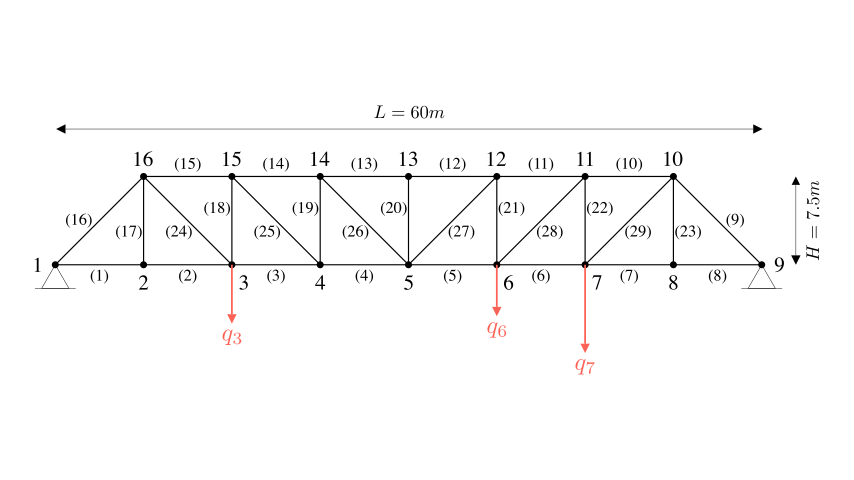

In [134]:
class TrussWithParams(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(5.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [[i * 7.5, 0, 0] for i in range(9)] +
            [[60 - (i + 1) * 7.5, 7.5, 0] for i in range(7)],
            dtype=float
        )
        connectivity_matrix = np.array(
            [[i, i + 1] for i in range(15)] +
            [[0, 15]] +
            [[i, 16 - i] for i in range(1, 8)] +
            [[i, 17 - i] for i in range(2, 5)] +
            [[i, 15 - i] for i in range(4, 7)],
            dtype=int
        )

        supports = {0: (True, True), 8: (True, True)}

        A = [.1] * len(connectivity_matrix)
        E = [210e9] * len(connectivity_matrix)

        loads = {2: (0., -2000.e3), 5: (0., -1750.e3), 6: (0., -3000.e3)}
        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  display_loads=True,
                  loads=loads,
                  displacements=u,
                  display_load_labels=True,
                  display_node_labels=True,
                  display_member_labels=True,
                  load_style={'scale': 7.5, 'stroke_width': 15},
                  load_label_style={'font_size': 200, 'text_class': Tex, 'prefix': r'\textbf{', 'suffix': '}'},
                  load_labels=['$q_3$', '$q_6$', '$q_7$'],
                  tip_style={'tip_width': .8, 'tip_length': .8},
                  node_label_style={'font_size': 130},
                  node_label_offsets=[1.5 * LEFT, 1.5 * DOWN, 1.5 * DOWN + RIGHT] + [1.5 * DOWN for _ in range(2)] +
                                     [1.5 * DOWN + RIGHT, 1.5 * DOWN + RIGHT, 1.5 * DOWN, 1.5 * RIGHT] +
                                     [1.5 * UP for _ in range(7)],
                  member_label_style={'font_size': 100},
                  member_label_offsets=[DOWN for _ in range(8)] + [1.5 * RIGHT] +
                                       [UP for _ in range(6)] + [1.75 * LEFT, DOWN + 1.25 * LEFT] +
                                       [UP + 1.25 * LEFT for _ in range(3)] + [UP + 1.25 * RIGHT for _ in range(2)] +
                                       [DOWN + 1.25 * RIGHT] + [DOWN + .75 * LEFT for _ in range(3)] +
                                       [DOWN + .75 * RIGHT for _ in range(3)],
                  member_style={'stroke_width': 10},
                  node_style={'radius': .3},
                  support_style={'height': 2},
                  deformed_style={'dash_length': .75, 'stroke_width': 20})

        g.move_to(ORIGIN)
        g.update()
        for load, label in zip(g.loads, g.loads_labels):
            label.next_to(load, DOWN, buff=.5)

        width_measure = VGroup(Line(g.nodes[0].get_center(), g.nodes[8].get_center(), color=BLACK)
                               .add_tip(**g._tip_style)
                               .add_tip(**g._tip_style, at_start=True)
                               .next_to(g, UP, buff=1.5))
        width_measure.add(Tex('$L=60m$', font_size=150, color=BLACK).next_to(width_measure, UP, buff=.5))

        height_measure = VGroup(Line(g.nodes[1].get_center(), g.nodes[15].get_center(), color=BLACK)
                                .add_tip(**g._tip_style)
                                .add_tip(**g._tip_style, at_start=True)
                                .next_to(g.members[8], RIGHT, buff=2.5))
        height_measure.add(Tex('$H=7.5m$', font_size=150, color=BLACK)
                           .rotate(PI / 2)
                           .next_to(height_measure, RIGHT, buff=.5))

        self.add(g, width_measure, height_measure)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/04-truss_params.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING TrussWithParams

In [139]:
a = np.array(
    [[i, i + 1] for i in range(15)] +
    [[0, 15]] +
    [[i, 16 - i] for i in range(1, 8)] +
    [[i, 17 - i] for i in range(2, 5)] +
    [[i, 15 - i] for i in range(4, 7)],
    dtype=int
)


{np.int64(0): np.int64(2),
 np.int64(1): np.int64(3),
 np.int64(2): np.int64(4),
 np.int64(3): np.int64(4),
 np.int64(4): np.int64(5),
 np.int64(5): np.int64(4),
 np.int64(6): np.int64(4),
 np.int64(7): np.int64(3),
 np.int64(8): np.int64(2),
 np.int64(9): np.int64(4),
 np.int64(10): np.int64(4),
 np.int64(11): np.int64(4),
 np.int64(12): np.int64(3),
 np.int64(13): np.int64(4),
 np.int64(14): np.int64(4),
 np.int64(15): np.int64(4)}

Manim Community v0.19.0

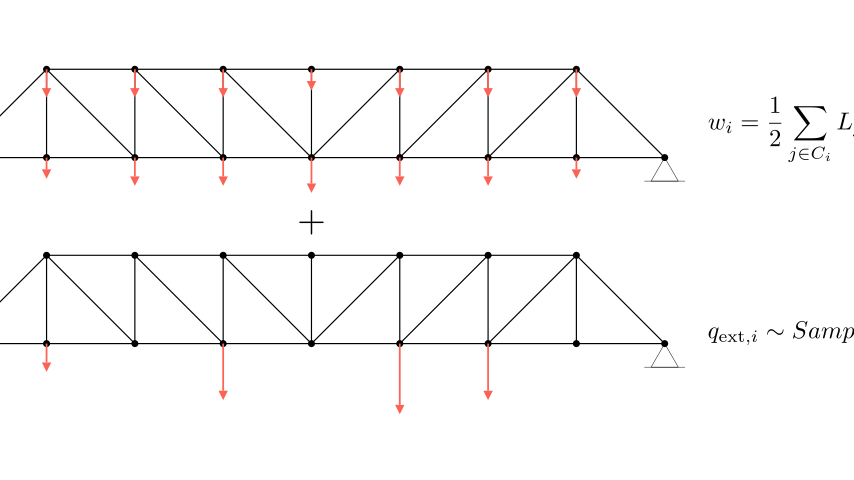

In [238]:
class LoadComposition(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(5.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [[i * 7.5, 0, 0] for i in range(9)] +
            [[60 - (i + 1) * 7.5, 7.5, 0] for i in range(7)],
            dtype=float
        )

        connectivity_matrix = np.array(
            [[i, i + 1] for i in range(15)] +
            [[0, 15]] +
            [[i, 16 - i] for i in range(1, 8)] +
            [[i, 17 - i] for i in range(2, 5)] +
            [[i, 15 - i] for i in range(4, 7)],
            dtype=int
        )

        supports = {0: (True, True), 8: (True, True)}

        loads = dict(zip(*np.unique(a, return_counts=True)))
        del loads[0], loads[8]
        loads = {k: (0, -v) for k, v in loads.items()}

        g_1 = Truss(nodes=nodes,
                    connectivity_matrix=connectivity_matrix,
                    supports=supports,
                    display_loads=True,
                    loads=loads,
                    display_load_labels=False,
                    display_node_labels=False,
                    display_member_labels=False,
                    load_style={'scale': 3, 'stroke_width': 15},
                    tip_style={'tip_width': .8, 'tip_length': .8},
                    member_style={'stroke_width': 10},
                    node_style={'radius': .3},
                    support_style={'height': 2},
                    deformed_style={'dash_length': .75, 'stroke_width': 15})

        g_1.move_to(ORIGIN)
        g_1.update()

        loads = {1: (0., -1000.e3), 3: (0., -2000.e3), 5: (0., -2500.e3), 6: (0., -2000.e3)}
        g_2 = Truss(nodes=nodes,
                    connectivity_matrix=connectivity_matrix,
                    supports=supports,
                    display_loads=True,
                    loads=loads,
                    display_load_labels=False,
                    display_node_labels=False,
                    display_member_labels=False,
                    load_style={'scale': 6, 'stroke_width': 15},
                    tip_style={'tip_width': .8, 'tip_length': .8},
                    member_style={'stroke_width': 10},
                    node_style={'radius': .3},
                    support_style={'height': 2},
                    deformed_style={'dash_length': .75, 'stroke_width': 15})

        g_2.next_to(g_1, DOWN, buff=5)
        g_2.update()

        sampling_1 = (Tex(r'$$w_{i}=\frac{1}{2}\sum_{j\in C_i} {L_j A_j \rho g}$$', color=BLACK, font_size=200)
                      .next_to(g_1, RIGHT, buff=2))
        sampling_2 = (Tex(r'$$q_{\text{ext}, i} \sim Sampling$$', color=BLACK, font_size=200)
                      .next_to(g_2, RIGHT, buff=2))

        addition = (Tex(r'$$+$$', color=BLACK, font_size=300)
                    .move_to(g_1.get_bottom() + .5 * (g_2.get_top() - g_1.get_bottom())))

        self.add(g_1, g_2, sampling_1, sampling_2, addition)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/04-load_composition.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING LoadComposition

Manim Community v0.19.0

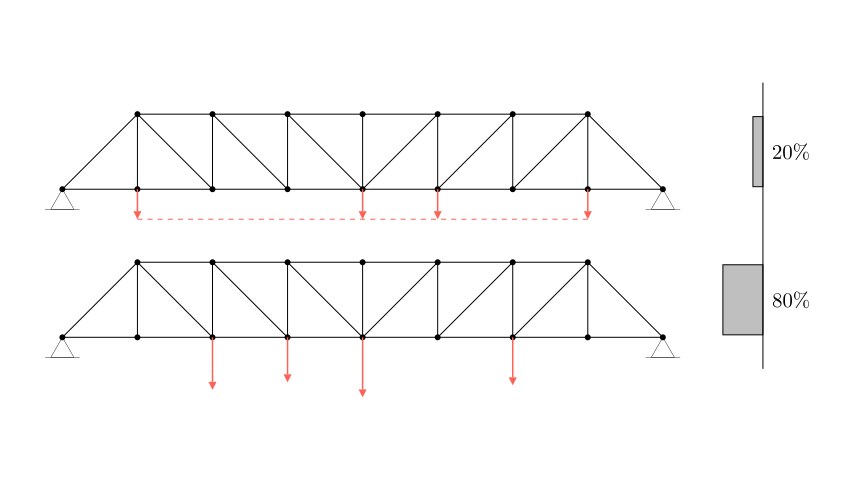

In [171]:
class GeneratedLoad(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(6)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [[i * 7.5, 0, 0] for i in range(9)] +
            [[60 - (i + 1) * 7.5, 7.5, 0] for i in range(7)],
            dtype=float
        )

        connectivity_matrix = np.array(
            [[i, i + 1] for i in range(15)] +
            [[0, 15]] +
            [[i, 16 - i] for i in range(1, 8)] +
            [[i, 17 - i] for i in range(2, 5)] +
            [[i, 15 - i] for i in range(4, 7)],
            dtype=int
        )

        supports = {0: (True, True), 8: (True, True)}

        loads = {1: (0., -2000.e3), 4: (0., -2000.e3), 5: (0., -2000.e3), 7: (0., -2000.e3)}
        g_1 = Truss(nodes=nodes,
                    connectivity_matrix=connectivity_matrix,
                    supports=supports,
                    display_loads=True,
                    loads=loads,
                    display_load_labels=False,
                    display_node_labels=False,
                    display_member_labels=False,
                    load_style={'scale': 3, 'stroke_width': 15},
                    tip_style={'tip_width': .8, 'tip_length': .8},
                    member_style={'stroke_width': 10},
                    node_style={'radius': .3},
                    support_style={'height': 2},
                    deformed_style={'dash_length': .75, 'stroke_width': 15})

        g_1.move_to(ORIGIN)
        g_1.update()

        g_1.add(DashedLine(g_1.loads[0].get_end(), g_1.loads[-1].get_end(),
                           color=RED, dash_length=.5, stroke_width=10))

        loads = {2: (0., -1750.e3), 3: (0., -1500.e3), 4: (0., -2000.e3), 6: (0., -1600.e3)}
        g_2 = Truss(nodes=nodes,
                    connectivity_matrix=connectivity_matrix,
                    supports=supports,
                    display_loads=True,
                    loads=loads,
                    display_load_labels=False,
                    display_node_labels=False,
                    display_member_labels=False,
                    load_style={'scale': 6, 'stroke_width': 15},
                    tip_style={'tip_width': .8, 'tip_length': .8},
                    member_style={'stroke_width': 10},
                    node_style={'radius': .3},
                    support_style={'height': 2},
                    deformed_style={'dash_length': .75, 'stroke_width': 15})

        g_2.next_to(g_1, DOWN, buff=4)
        g_2.update()

        ratios = VGroup(
            Line([0, g_1.get_top()[1], 0], [0, g_2.get_bottom()[1], 0], color=BLACK, stroke_width=10).next_to(
                VGroup(g_1.members, g_2.members), RIGHT, buff=10))
        ratios.add(Rectangle(width=1, height=7, color=BLACK, stroke_width=10, fill_opacity=.25).next_to(g_1.members,
                                                                                                        RIGHT).align_to(
            ratios[0], RIGHT))
        ratios.add(Rectangle(width=4, height=7, color=BLACK, stroke_width=10, fill_opacity=.25).next_to(g_2.members,
                                                                                                        RIGHT).align_to(
            ratios[0], RIGHT))

        labels = VGroup(*[
            Tex(r'$20\%$', color=BLACK, font_size=200).next_to(ratios[1], buff=1),
            Tex(r'$80\%$', color=BLACK, font_size=200).next_to(ratios[2], buff=1)
        ])

        self.add(g_1, g_2, ratios, labels)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/04-generated_load.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING GeneratedLoad

Manim Community v0.19.0

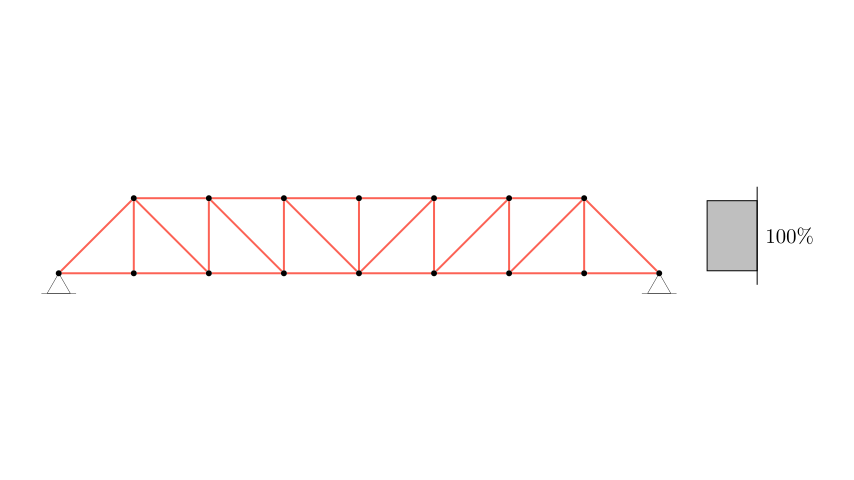

In [3]:
import random

random.seed(18)


class UniformEA(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(6)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [[i * 7.5, 0, 0] for i in range(9)] +
            [[60 - (i + 1) * 7.5, 7.5, 0] for i in range(7)],
            dtype=float
        )

        connectivity_matrix = np.array(
            [[i, i + 1] for i in range(15)] +
            [[0, 15]] +
            [[i, 16 - i] for i in range(1, 8)] +
            [[i, 17 - i] for i in range(2, 5)] +
            [[i, 15 - i] for i in range(4, 7)],
            dtype=int
        )

        supports = {0: (True, True), 8: (True, True)}

        loads = {}
        g = VGroup(*[Truss(nodes=nodes,
                           connectivity_matrix=connectivity_matrix,
                           supports=supports,
                           display_loads=True,
                           loads=loads,
                           display_load_labels=False,
                           display_node_labels=False,
                           display_member_labels=False,
                           load_style={'scale': 3, 'stroke_width': 20},
                           tip_style={'tip_width': .8, 'tip_length': .8},
                           member_style={'stroke_width': 20},
                           node_style={'radius': .3},
                           support_style={'height': 2},
                           deformed_style={'dash_length': .75, 'stroke_width': 15})
                     for _ in range(1)]
                   )

        for member in g[0].members:
            member.set(color=RED)

        for i in range(1, len(g)):
            g[i].next_to(g[i - 1], DOWN, buff=4)

        ratios = VGroup(Line([0, g[0].get_top()[1], 0], [0, g[-1].get_bottom()[1], 0], color=BLACK, stroke_width=10)
                        .next_to(VGroup([g_i.members for g_i in g]), RIGHT, buff=10))

        ratios.add(Rectangle(width=5, height=7, color=BLACK, stroke_width=10, fill_opacity=.25)
                   .next_to(g[0].members, RIGHT).align_to(ratios[0], RIGHT))

        labels = VGroup(*[
            Tex(r'$100\%$', color=BLACK, font_size=200).next_to(ratios[1], buff=1),
        ])

        self.add(g, ratios, labels)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/04-uniform_ea.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING UniformEA

Manim Community v0.19.0

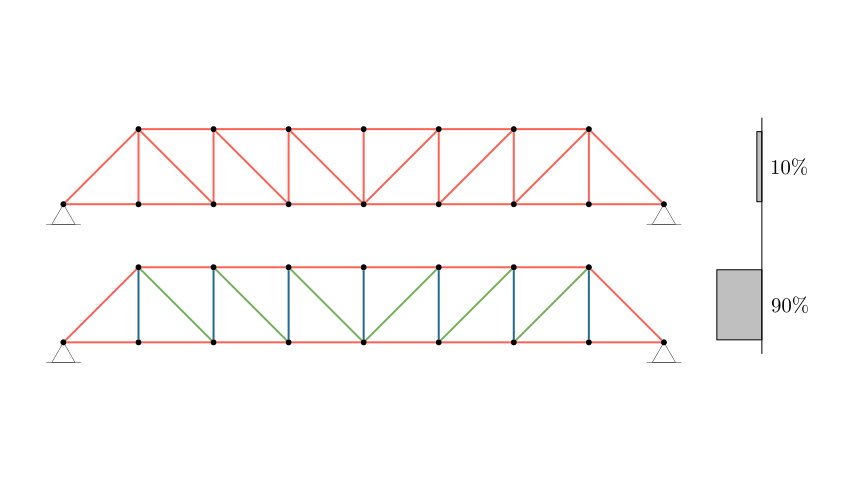

In [4]:
import random

random.seed(18)


class CategoryEA(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(6)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [[i * 7.5, 0, 0] for i in range(9)] +
            [[60 - (i + 1) * 7.5, 7.5, 0] for i in range(7)],
            dtype=float
        )

        connectivity_matrix = np.array(
            [[i, i + 1] for i in range(15)] +
            [[0, 15]] +
            [[i, 16 - i] for i in range(1, 8)] +
            [[i, 17 - i] for i in range(2, 5)] +
            [[i, 15 - i] for i in range(4, 7)],
            dtype=int
        )

        supports = {0: (True, True), 8: (True, True)}

        loads = {}
        g = VGroup(*[Truss(nodes=nodes,
                           connectivity_matrix=connectivity_matrix,
                           supports=supports,
                           display_loads=True,
                           loads=loads,
                           display_load_labels=False,
                           display_node_labels=False,
                           display_member_labels=False,
                           load_style={'scale': 3, 'stroke_width': 20},
                           tip_style={'tip_width': .8, 'tip_length': .8},
                           member_style={'stroke_width': 20},
                           node_style={'radius': .3},
                           support_style={'height': 2},
                           deformed_style={'dash_length': .75, 'stroke_width': 15})
                     for _ in range(2)]
                   )

        for member in g[0].members:
            member.set(color=RED)

        for member in g[1].members[:16]:
            member.set(color=RED)
        for member in g[1].members[16:23]:
            member.set(color=DARK_BLUE)
        for member in g[1].members[23:]:
            member.set(color=GREEN_D)

        for i in range(1, len(g)):
            g[i].next_to(g[i - 1], DOWN, buff=4)

        ratios = VGroup(Line([0, g[0].get_top()[1], 0], [0, g[-1].get_bottom()[1], 0], color=BLACK, stroke_width=10)
                        .next_to(VGroup([g_i.members for g_i in g]), RIGHT, buff=10))

        ratios.add(Rectangle(width=.5, height=7, color=BLACK, stroke_width=10, fill_opacity=.25)
                   .next_to(g[0].members, RIGHT).align_to(ratios[0], RIGHT))
        ratios.add(Rectangle(width=4.5, height=7, color=BLACK, stroke_width=10, fill_opacity=.25)
                   .next_to(g[1].members, RIGHT).align_to(ratios[0], RIGHT))

        labels = VGroup(*[
            Tex(r'$10\%$', color=BLACK, font_size=200).next_to(ratios[1], buff=1),
            Tex(r'$90\%$', color=BLACK, font_size=200).next_to(ratios[2], buff=1)
        ])

        self.add(g, ratios, labels)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/04-category_ea.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING CategoryEA

Manim Community v0.19.0

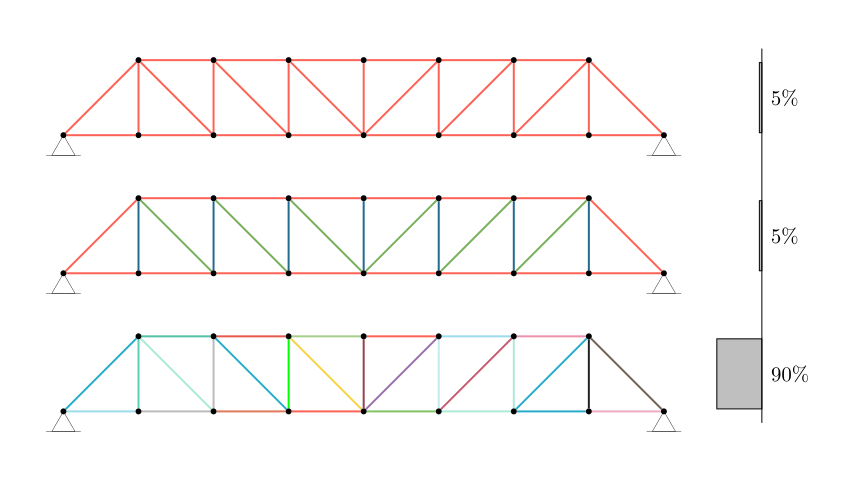

In [5]:
import random

random.seed(18)


class MemberEA(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(6)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [[i * 7.5, 0, 0] for i in range(9)] +
            [[60 - (i + 1) * 7.5, 7.5, 0] for i in range(7)],
            dtype=float
        )

        connectivity_matrix = np.array(
            [[i, i + 1] for i in range(15)] +
            [[0, 15]] +
            [[i, 16 - i] for i in range(1, 8)] +
            [[i, 17 - i] for i in range(2, 5)] +
            [[i, 15 - i] for i in range(4, 7)],
            dtype=int
        )

        supports = {0: (True, True), 8: (True, True)}

        loads = {}
        g = VGroup(*[Truss(nodes=nodes,
                           connectivity_matrix=connectivity_matrix,
                           supports=supports,
                           display_loads=True,
                           loads=loads,
                           display_load_labels=False,
                           display_node_labels=False,
                           display_member_labels=False,
                           load_style={'scale': 3, 'stroke_width': 20},
                           tip_style={'tip_width': .8, 'tip_length': .8},
                           member_style={'stroke_width': 20},
                           node_style={'radius': .3},
                           support_style={'height': 2},
                           deformed_style={'dash_length': .75, 'stroke_width': 15})
                     for _ in range(3)]
                   )

        for member in g[0].members:
            member.set(color=RED)

        for member in g[1].members[:16]:
            member.set(color=RED)
        for member in g[1].members[16:23]:
            member.set(color=DARK_BLUE)
        for member in g[1].members[23:]:
            member.set(color=GREEN_D)

        for member in g[2].members:
            member.set(color=random_color())

        for i in range(1, len(g)):
            g[i].next_to(g[i - 1], DOWN, buff=4)

        ratios = VGroup(Line([0, g[0].get_top()[1], 0], [0, g[-1].get_bottom()[1], 0], color=BLACK, stroke_width=10)
                        .next_to(VGroup([g_i.members for g_i in g]), RIGHT, buff=10))

        ratios.add(Rectangle(width=.25, height=7, color=BLACK, stroke_width=10, fill_opacity=.25)
                   .next_to(g[0].members, RIGHT).align_to(ratios[0], RIGHT))
        ratios.add(Rectangle(width=.25, height=7, color=BLACK, stroke_width=10, fill_opacity=.25)
                   .next_to(g[1].members, RIGHT).align_to(ratios[0], RIGHT))
        ratios.add(Rectangle(width=4.5, height=7, color=BLACK, stroke_width=10, fill_opacity=.25)
                   .next_to(g[2].members, RIGHT).align_to(ratios[0], RIGHT))

        labels = VGroup(*[
            Tex(r'$5\%$', color=BLACK, font_size=200).next_to(ratios[1], buff=1),
            Tex(r'$5\%$', color=BLACK, font_size=200).next_to(ratios[2], buff=1),
            Tex(r'$90\%$', color=BLACK, font_size=200).next_to(ratios[3], buff=1)
        ])

        self.add(g, ratios, labels)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/04-member_ea.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING MemberEA

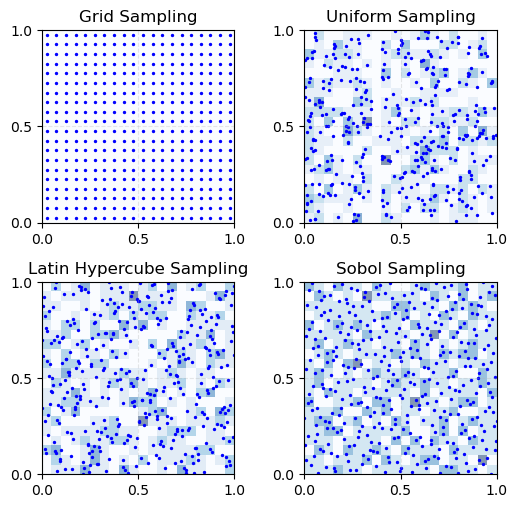

In [246]:
import matplotlib.pyplot as plt
from scipy.stats import qmc

# Number of samples
n_points = 400
n_side = int(np.sqrt(n_points))  # For grid

# Sampling methods
# 1. Grid sampling
x_grid = np.linspace(0, 1, n_side, endpoint=False) + 0.5 / n_side
X_grid = np.array(np.meshgrid(x_grid, x_grid)).reshape(2, -1).T

# 2. Uniform random sampling
X_uniform = np.random.rand(n_points, 2)

# 3. Latin Hypercube Sampling
sampler_lhs = qmc.LatinHypercube(d=2)
X_lhs = sampler_lhs.random(n=n_points)

# 4. Sobol Sampling
sampler_sobol = qmc.Sobol(d=2, scramble=True)
X_sobol = sampler_sobol.random_base2(m=9)  # 2^9 = 512 > 400
X_sobol = X_sobol[:n_points]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(5.4, 5.4))
methods = ['Grid', 'Uniform', 'Latin Hypercube', 'Sobol']
samples = [X_grid, X_uniform, X_lhs, X_sobol]

for ax, method, X in zip(axs.flat, methods, samples):
    # 2D histogram for density
    ax.hist2d(X[:, 0], X[:, 1], bins=20, range=[[0, 1], [0, 1]],
              cmap='Blues', alpha=0.5)

    # Scatter plot on top
    ax.scatter(X[:, 0], X[:, 1], color='blue', s=2)

    ax.set_title(f"{method} Sampling", fontsize=12)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("img/04_sampling_density_comparison.pdf")
plt.show()
